C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\macov\anaconda3\envs\lab\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


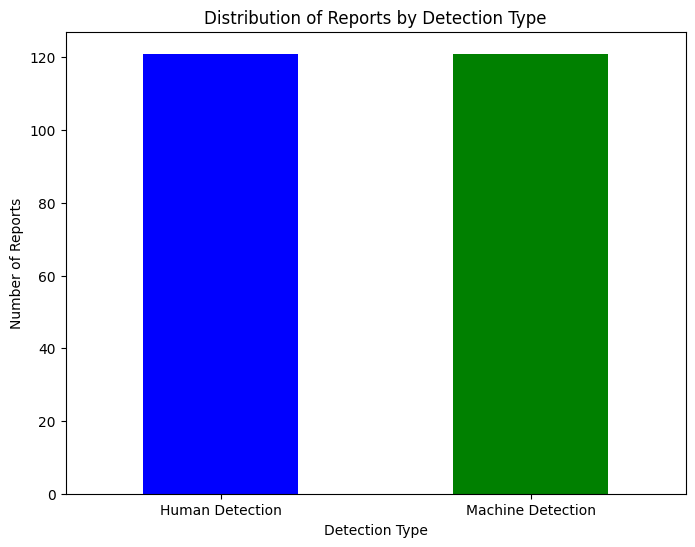

In [2]:
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data
data = pd.read_csv("reports_data.csv", index_col=0)

# Clean text
def clean_html(html):
    soup = BeautifulSoup(html, "html.parser")
    for data in soup(['style', 'script', 'code', 'a']):
        data.decompose()
    return ' '.join(soup.stripped_strings)

def clean_string(text, stem="None"):
    text = text.lower()
    text = re.sub(r'\n', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + ['hi', 'im']
    text_filtered = [word for word in text if not word in useless_words]
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered
    final_string = ' '.join(text_stemmed)
    return final_string

data['Report_Content_Clean'] = data['Report_Content'].apply(lambda x: clean_html(x))
data['Report_Content_Clean'] = data['Report_Content_Clean'].apply(lambda x: clean_string(x, stem='Stem'))

# Preprocess text
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['Report_Content_Clean'])

# Apply NMF
num_clusters = 2  # Set to the desired number of clusters
nfm_model = NMF(n_components=num_clusters, random_state=42)
nfm_model.fit(dtm)

# Obtain topic labels
topic_clusters = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(nfm_model.components_)
cluster_labels = {0: "Human Detection", 1: "Machine Detection"}
topic_labels = [cluster_labels[cluster] for cluster in topic_clusters] * len(data)

# Assign topic labels to reports
data['Topic_Label'] = topic_labels[:len(data)]

# Count the number of reports in each category
category_counts = data['Topic_Label'].value_counts()

# Plot the distribution of reports by category
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of Reports by Detection Type')
plt.xlabel('Detection Type')
plt.ylabel('Number of Reports')
plt.xticks(rotation=0)
plt.show()
